# Sheet 5

Julian Kusch, Jan Reckermann, Tim Weinreich

In [2]:
import os
import pandas as pd
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

## 1 The logistic sigmoid

#### a)

In [3]:
x = sp.symbols('x')
sigmoid = 1 / (1 + sp.exp(-x))
sigmoid_prime = sigmoid.diff(x)
sigmoid_prime

exp(-x)/(1 + exp(-x))**2

#### b)

In [4]:
x = sp.symbols('x')
tanh = (sp.exp(x) - sp.exp(-x)) / (sp.exp(x) + sp.exp(-x))
tanh_prime = sp.simplify(tanh.diff(x))
tanh_prime

4*exp(2*x)/(exp(4*x) + 2*exp(2*x) + 1)

with $2x = -x^\prime$ and dropping the const $C = 4$ the two derivatives are the same. That shows that $\tanh(x)$ is a shifted and scaled version of $\sigma(x)$.

#### c)

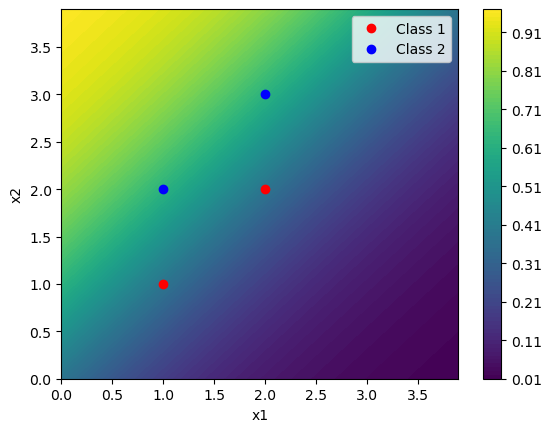

In [5]:
x1 = np.array([1, 2])
x2 = np.array([1, 2])

y1 = np.array([1, 2])
y2 = np.array([2, 3])

def sigmoid(x1, x2):
    return 1 / (1 + np.exp(1*x1 - 1*x2 + 1/2))  # 1/2 is the bias and w1 = 1 and w2 = -1

a1 = np.arange(0,4,0.1)
a2 = np.arange(0,4,0.1)

values = np.zeros((len(a1), len(a2)))

for i,a in enumerate(a1):
    for j,b in enumerate(a2):
        values[i,j] = sigmoid(a, b)

plt.contourf(a1, a2, values.T, levels=100)
plt.colorbar()
plt.plot(x1, y1, 'ro', label='Class 1')
plt.plot(x2, y2, 'bo', label='Class 2')
plt.xlabel('x1')
plt.ylabel('x2')   
plt.legend()

with $b = 1/2$ and $w^T = (1, -1)$ the activation seperates the two classes.

## 2 Logistic regression: an LLM lie detector

Download the data from https://heibox.uni-heidelberg.de/f/38bd3f2a9b7944248cc2/   
Unzip it and place the lie_detection folder in the folder named `data` to get the following structure:
"data/lie_detection/datasets" and "data/lie_detection/acts".

This is how you can load a dataset of LLM activations. Use a new Datamanager if you want to have a new dataset. Use the same data manager if you want to combine datasets.

In [6]:
from lie_detection_utils import DataManager

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

# check if the datasets and activations are available
assert os.path.exists(path_to_datasets), "The path to the datasets does not exist."
assert os.path.exists(path_to_acts), "The path to the activations does not exist."

# these are the different datasets containing true and false factual statements about different topics
dataset_names = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans"]
dataset_name = dataset_names[0] # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example

# the dataloader automatically loads the training data for us
dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train, labels_train = dm.get('train') # train set
acts_test, labels_test = dm.get('val')
print(acts_train.shape, labels_train.shape)

ModuleNotFoundError: No module named 'torch'

In [ ]:
# have a look at the statements that were fed to the LLM to produce the activations:
df = pd.read_csv(f"{path_to_datasets}/{dataset_name}.csv")
print(df.head(10))

## 3 Log-sum-exp and soft(arg)max
### (a)

In [7]:
lambda_ = 1
sigma1 = np.array([1, 2, 3])
sigma2 = np.array([11, 12, 13])
sigma3 = np.array([10, 20, 30])

def softmax(x, l):
    return np.exp(l*x) / np.sum(np.exp(l*x), axis=0)

print(softmax(sigma1, lambda_))
print(softmax(sigma2, lambda_))
print(softmax(sigma3, lambda_))

[0.09003057 0.24472847 0.66524096]
[0.09003057 0.24472847 0.66524096]
[2.06106005e-09 4.53978686e-05 9.99954600e-01]


$\sigma_1$ and $\sigma_2$ yield identical results.

### (b)

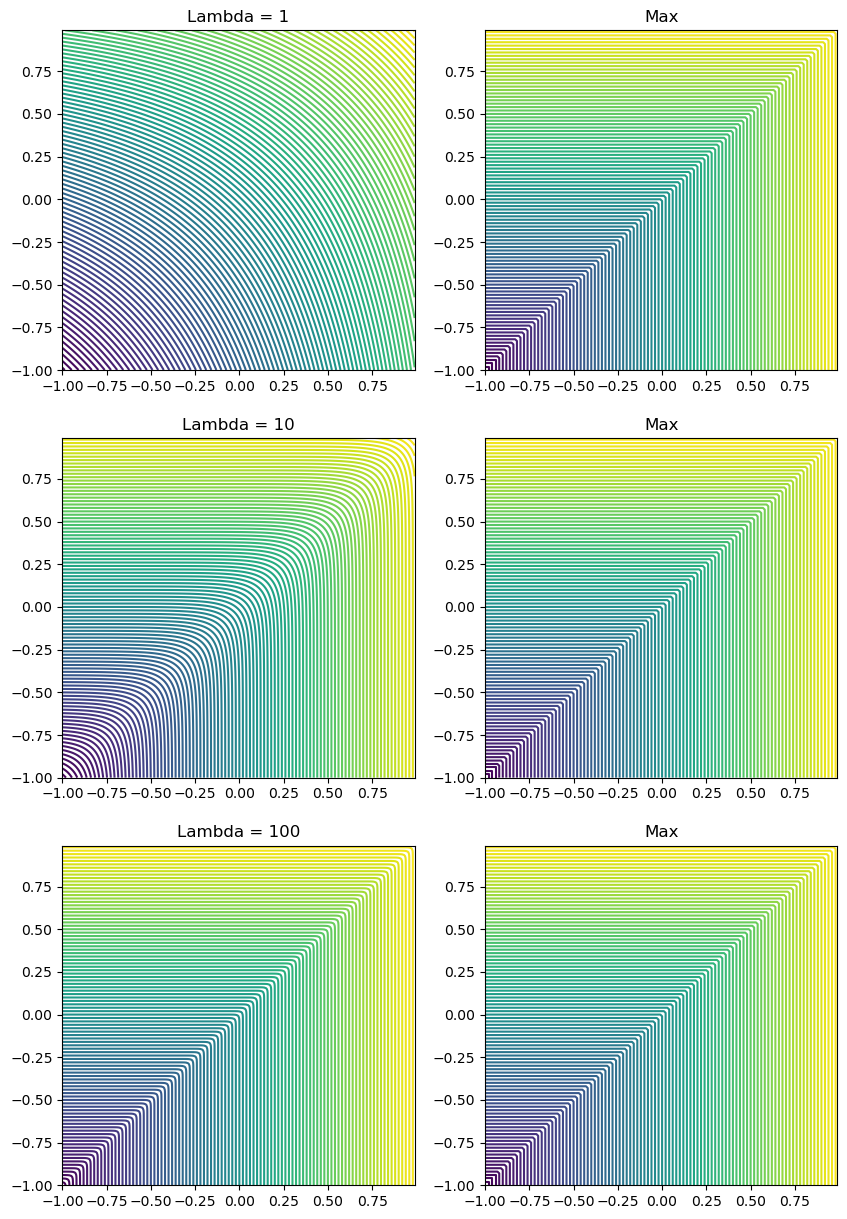

In [8]:
s1 = np.arange(-1, 1, 0.01)
s2 = np.arange(-1, 1, 0.01)

lambdas = [1, 10, 100]

def lse(x, l):
    return 1/l * np.log(np.sum(np.exp(l*x), axis=0))

values = np.zeros((len(s1), len(s2), len(lambdas)))
max_vals = np.zeros((len(s1), len(s2)))

for i,a in enumerate(s1):
    for j,b in enumerate(s2):
        max_vals[i,j] = np.max([a,b])
        for k,l in enumerate(lambdas):
            values[i,j,k] = lse(np.array([a, b]), l)

fig, ax = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    ax[i,0].contour(s1, s2, values[:,:,i].T, levels=100)
    ax[i,0].set_title(f"Lambda = {lambdas[i]}")
    ax[i,1].contour(s1, s2, max_vals.T, levels=100)
    ax[i,1].set_title("Max")

#### c)

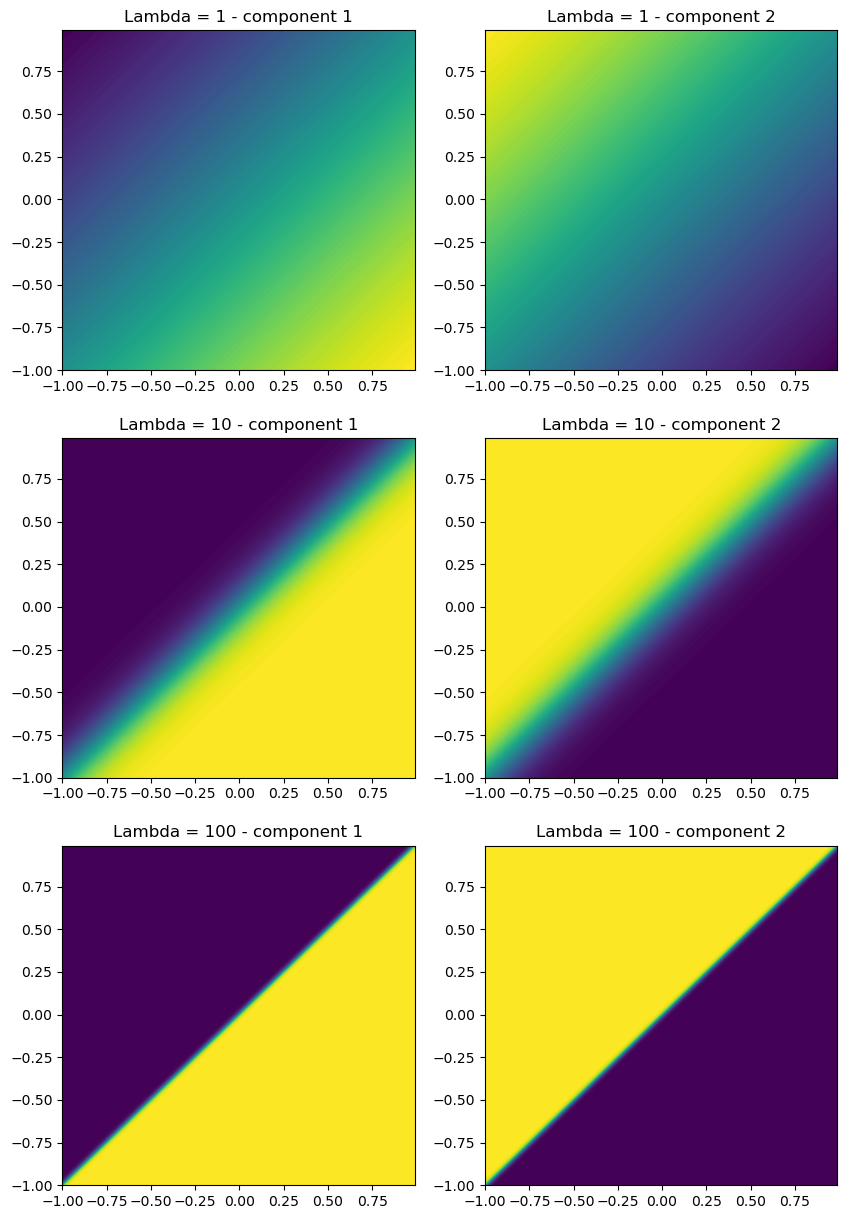

In [9]:
values0 = np.zeros((len(s1), len(s2), len(lambdas)))
values1 = np.zeros((len(s1), len(s2), len(lambdas)))

for i,a in enumerate(s1):
    for j,b in enumerate(s2):
        for k,l in enumerate(lambdas):
            values0[i,j,k] = softmax(np.array([a, b]), l)[0]
            values1[i,j,k] = softmax(np.array([a, b]), l)[1]

fig, ax = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    ax[i,0].contourf(s1, s2, values0[:,:,i].T, levels=100)
    ax[i,0].set_title(f"Lambda = {lambdas[i]} - component 1")
    ax[i,1].contourf(s1, s2, values1[:,:,i].T, levels=100)
    ax[i,1].set_title(f"Lambda = {lambdas[i]} - component 2")

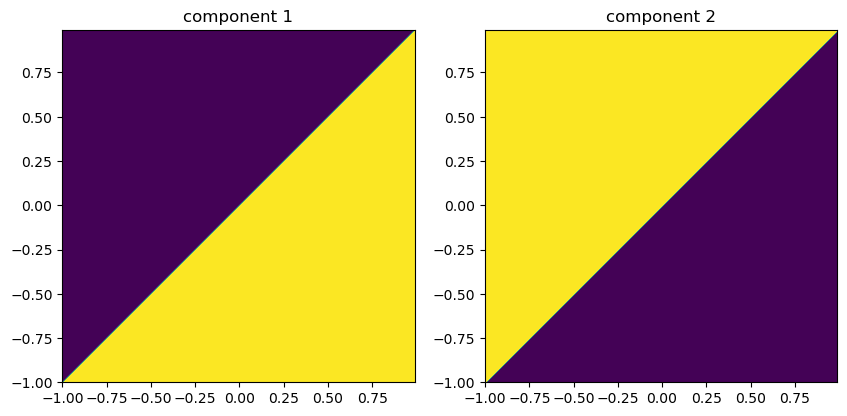

In [17]:
values0 = np.zeros((len(s1), len(s2)))
values1 = np.zeros((len(s1), len(s2)))

for i,a in enumerate(s1):
    for j,b in enumerate(s2):
        values0[i,j] = 1 if a > b else 0
        values1[i,j] = 0 if a > b else 1

fig, ax = plt.subplots(1, 2, figsize=(10, 4.7))
ax[0].contourf(s1, s2, values0.T, levels=100)
ax[0].set_title(f"component 1")
ax[1].contourf(s1, s2, values1.T, levels=100)
ax[1].set_title(f"component 2")
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

### d)
![alt text](image.png)

## 4 Linear regions of MLPs